## CASE TÉCNICO AILOS - ANALISTA DE MODELAGEM ESTATÍSTICA III

- Esse notebook procura sintetizar o processo de desenvolvimento do modelo de PD com base nos dados fornecidos. Os dicionários de variáveis e seus conceitos foram disponibilizados junto com esse material e buscam ser um guia para prototipação e melhoria contínua das ideias aqui apresentadas. Não tem como objetivo ser o documento mais adequado para ser posto em produção, mas ser o ponto focal dos esforços propostos.



#### 00. IMPORT DE PACOTES E FUNÇÕES ÚTEIS

- Módulos criados para o projeto também são carregados

In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn import model_selection
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from feature_engine.encoding import OneHotEncoder
from feature_engine import discretisation

from lightgbm import LGBMClassifier


pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

from pipeline.preprocess import *
from pipeline.utils import *
from pipeline.carregar_dados import *
from pipeline.criar_abt import *
from pipeline.utils import *

from features.features_clientes import *
from features.features_quantidade import *
from features.features_valor import *
from features.features_tempo import *
from features.features_flags import *
from features.features_clientes_transacional import *



#### 01. CARREGAR DADOS ORIGINAIS COM PRÉ-PROCESSAMENTO MÍNIMO

In [68]:
dados = carregar_dados()

df_clientes = dados['clientes']
df_inadimplencia = dados['inadimplencia']
df_transacoes = dados['transacoes']

clientes_prep = preprocessar_clientes(df_clientes)
inad_prep = preprocessar_inadimplencia(df_inadimplencia)
tran_prep = preprocessar_transacoes(df_transacoes)

# inad_prep = inad_prep.dropna(subset=["atraso_90d"]).copy()

print("Clientes:", clientes_prep.shape)
print("Inadimplência:", inad_prep.shape)
print("Transações:", tran_prep.shape)


Clientes: (200, 10)
Inadimplência: (4800, 4)
Transações: (2000, 4)


In [69]:
inad_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_cliente       4800 non-null   object        
 1   mes_safra        4800 non-null   object        
 2   data_referencia  4800 non-null   datetime64[ns]
 3   atraso_90d       4790 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 150.1+ KB


In [70]:
inad_prep.isna().mean()

id_cliente         0.000000
mes_safra          0.000000
data_referencia    0.000000
atraso_90d         0.002083
dtype: float64

**A variável resposta do modelo *atraso_90d* possui 10 casos com valores nulos na base de inadimplência (<0,5% dos registros), e por isso esses casos serão removidos.**

In [145]:
inad_prep = inad_prep.dropna(subset=["atraso_90d"]).copy()

#### 02. GERAÇÃO DA ABT 

- Merge com as bases de features criadas.

- Cada unidade experimental corresponderá ao par *id_cliente* + *data_referencia*, e as variáveis corresponderão a essa referência.

- A base que será utilizada durante todo o desenvolvimento teve os cálculos de suas features baseados numa janela de observação M-1, garantindo assim que não utilize dados do mesmo mês a que a coluna *mes_safra* da base de inadimplência se refere.

- Como será observado adiante, a taxa de inadimplência tem valor de 10%, o que pode gerar alguns problemas durante a modelagem devido ao desbalanceamento.

In [ ]:
abt_M1 = gerar_abt(clientes_prep, inad_prep, tran_prep, usar_M_1=True)

print("Shape M-1:", abt_M1.shape)

Shape M-1: (4790, 98)


##### 2.1 SALVANDO ABT

In [136]:
os.makedirs('../data/processed', exist_ok=True)

abt_M.to_parquet("../data/processed/abt_M.parquet", index=False)
abt_M1.to_parquet("../data/processed/abt_M1.parquet", index=False)

abt_M.to_csv("../data/processed/abt_M.csv", index=False)
abt_M1.to_csv("../data/processed/abt_M1.csv", index=False)


##### 2.2 MARCANDO COLUNAS

- Colunas retiradas pois não serão utilizadas no estudo para prever inadimplência.

In [133]:
cols_drop = ['id_cliente', 'data_referencia', 'data_abertura_conta', 'mes_abertura_conta','mes_safra']

##### 2.3. OHE para variáveis categóricas

In [ ]:
abt = aplicar_ohe_completo(abt_M1, excluir = cols_drop)

print("Shape original:", abt_M.shape)
print("Shape com OHE:", abt.shape)
print("Novas colunas:", set(abt.columns) - set(abt_M.columns))


Shape original: (4790, 98)
Shape com OHE: (4790, 102)
Novas colunas: {'estado_civil_solteiro', 'estado_civil_viuvo', 'estado_civil_casado', 'estado_civil_nan', 'estado_civil_divorciado'}


##### 2.4. Diagnóstico de %  de *missings* por variável e algumas estatísticas descritivas

In [135]:
diagnostico_abt(abt).head(20)

,variavel,tipo,pct_missing,n_unique,media,min,max
54,tempo_desde_ultima_1m,float64,71.61,31,12.725735,0.00,30.0
53,tempo_desde_primeira_1m,float64,71.61,31,16.958088,0.00,30.0
20,comp_vlr_1m_vs_3m,float64,49.83,592,0.336203,0.00,1.0
42,comp_qtde_1m_vs_3m,float64,49.79,19,0.336004,0.00,1.0
57,tempo_desde_ultima_3m,float64,49.79,92,30.912682,0.00,91.0
56,tempo_desde_primeira_3m,float64,49.79,92,59.648233,0.00,91.0
44,comp_qtde_3m_vs_6m,float64,35.41,40,0.498930,0.00,1.0
22,comp_vlr_3m_vs_6m,float64,35.41,743,0.494327,0.00,1.0
60,tempo_desde_ultima_6m,float64,35.41,182,53.622495,0.00,181.0
59,tempo_desde_primeira_6m,float64,35.41,184,128.218487,0.00,183.0


##### 2.5. Avaliação do valor do IV para cada variável para direcionamento dos possíveis preditores mais relevantes

In [ ]:
df_iv = avaliar_iv(abt, target="atraso_90d", top=30)
df_iv.head(30)


,IV
tempo_desde_primeira_1m,0.099517
tempo_desde_primeira_3m,0.043314
vlr_trans_max,0.042664
tempo_desde_primeira_6m,0.040421
vlr_trans_min,0.036257
tempo_emprego_anos,0.036028
tempo_desde_ultima_12m,0.034349
tempo_desde_ultima_24m,0.032790
tempo_desde_ultima_ever,0.032790
vlr_trans_ult,0.030856


#### Possíveis direcionamentos
- Tempo desde a primeira transação é a variável mais informativa.

- Valor máximo/mínimo e última transação também se destacam, assim como *tempo_emprego_anos*

- Variáveis cadastrais como idade e renda parecem mais fracas para prever inadimplência. 

- Nenhum IV acima de 0.1 pode indicar que não há leakage, fortalecendo a ideia de uma construção de variáveis de forma consistente.

##### 2.6. Remoção de variáveis

- IV abaixo do limiar é removido
- Correlação acima do limiar entre 2 variáveis elimina a que possui o menor IV 

In [ ]:
res = remover_vars(abt, target="atraso_90d", iv_threshold=0.02, corr_threshold=0.7)

print("Top variáveis por IV:")
res["iv_ranking"].head(20)


Top variáveis por IV:


,IV
tempo_desde_primeira_1m,0.099517
tempo_desde_primeira_3m,0.043314
vlr_trans_max,0.042664
tempo_desde_primeira_6m,0.040421
vlr_trans_min,0.036257
tempo_emprego_anos,0.036028
tempo_desde_ultima_12m,0.034349
tempo_desde_ultima_24m,0.032790
tempo_desde_ultima_ever,0.032790
vlr_trans_ult,0.030856


In [128]:
print("\nSelecionadas (IV ≥ 0.02):")
res["selecionadas_iniciais"]


Selecionadas (IV ≥ 0.02):


['tempo_desde_primeira_1m',
 'tempo_desde_primeira_3m',
 'vlr_trans_max',
 'tempo_desde_primeira_6m',
 'vlr_trans_min',
 'tempo_emprego_anos',
 'tempo_desde_ultima_12m',
 'tempo_desde_ultima_24m',
 'tempo_desde_ultima_ever',
 'vlr_trans_ult',
 'tempo_desde_ultima_3m',
 'idade_relativa',
 'comp_qtde_3m_vs_6m',
 'qtde_trans_12m',
 'tempo_desde_ultima_1m',
 'produtos_por_ano_conta',
 'produtos_por_mes_conta',
 'comp_vlr_3m_vs_6m',
 'tempo_relacionamento_anos',
 'tempo_relacionamento_meses',
 'tempo_desde_ultima_6m',
 'renda_por_limite']

In [129]:
print("\nRemovidas por correlação:")
res["removidas_corr"]


Removidas por correlação:


['tempo_relacionamento_meses',
 'comp_qtde_3m_vs_6m',
 'comp_vlr_3m_vs_6m',
 'tempo_desde_ultima_6m',
 'tempo_desde_ultima_3m',
 'tempo_desde_ultima_ever',
 'tempo_desde_ultima_24m',
 'produtos_por_mes_conta',
 'tempo_relacionamento_anos',
 'tempo_desde_ultima_1m',
 'produtos_por_ano_conta']

In [123]:
print("\nVariáveis finais:")
res["final"]


Variáveis finais:


['tempo_desde_primeira_1m',
 'tempo_desde_primeira_3m',
 'vlr_trans_max',
 'tempo_desde_primeira_6m',
 'vlr_trans_min',
 'tempo_emprego_anos',
 'tempo_desde_ultima_12m',
 'vlr_trans_ult',
 'idade_relativa',
 'qtde_trans_12m',
 'renda_por_limite']

In [124]:
res['iv_ranking'].head(10)

,IV
tempo_desde_primeira_1m,0.099517
tempo_desde_primeira_3m,0.043314
vlr_trans_max,0.042664
tempo_desde_primeira_6m,0.040421
vlr_trans_min,0.036257
tempo_emprego_anos,0.036028
tempo_desde_ultima_12m,0.034349
tempo_desde_ultima_24m,0.032790
tempo_desde_ultima_ever,0.032790
vlr_trans_ult,0.030856


## 3. MODELAGEM

- Essa seção se propõe a trazer alguns modelos que podem servir como baseline num primeiro momento para que um refinamento posterior possa melhorar o desempenho.

- Inicialmente serão testados 2 modelos: a regressão logística, que é um modelo altamente explicativo por conta dos seus coeficientes que dão a dimensão do impacto de suas variáveis; e o modelo LightGBM.

- As etapas seguintes vão executar as etapas tradicionais da modelagem: definição do *target*, separação em base de treino e teste, tratamento de colunas categóricas e conversão em numéricas através de One-hot encoding, treinamento em si e avaliação com algumas métricas como acurácia, precisão, recall e F1-Score. 

- Como demonstrado abaixo, a taxa de inadimplência tem valor aproximado de 10%, o que pode representar um desafio quanto à questão do desbalanceamento entre as classes.

In [166]:
features_final = res["final"]
X = abt[features_final].copy()
y = abt["atraso_90d"]

#  Detectar variáveis categóricas
cat_features = [col for col in X.columns if X[col].dtype.name == "category"]

features_final = res["final"]
X = abt[features_final].copy()
y = abt["atraso_90d"]


In [165]:
X.shape

(4790, 11)

- O setup dos modelos teve alguns detalhes que convém chamar atenção: o modelo de regressão logística no scikit-learn não aceita nativamente valores nulos nas colunas. Assim, foi criada uma flag -99 para cobrir esses casos. Assim como variáveis categóricas passaram pelo processo de One-hot encoding, como mencionado anteriormente.

- As avaliações levaram em conta métricas como AUC, precisão, recall e F1-score. Acurácia também é exibida, mas possui uma importância e significado menos relevante nesse contexto devido ao desbalanceamneto.

In [168]:
# ===============================
# PREPARAÇÃO PARA REGRESSÃO LOGÍSTICA
# ===============================
from feature_engine.encoding import OneHotEncoder

def preparar_logit(X_train, X_test, cat_features):
    X_train_logit = X_train.copy()
    X_test_logit  = X_test.copy()

    # Para variáveis numéricas: criar flag e imputar -99
    for col in X_train_logit.columns:
        if col not in cat_features:
            X_train_logit[col + "_isna"] = X_train_logit[col].isna().astype(int)
            X_test_logit[col + "_isna"]  = X_test_logit[col].isna().astype(int)
            X_train_logit[col] = X_train_logit[col].fillna(-99)
            X_test_logit[col]  = X_test_logit[col].fillna(-99)

    # Para categóricas: imputar "missing" e aplicar OHE
    if cat_features:
        for col in cat_features:
            X_train_logit[col] = X_train_logit[col].astype("object").fillna("missing")
            X_test_logit[col]  = X_test_logit[col].astype("object").fillna("missing")

        ohe = OneHotEncoder(variables=cat_features, ignore_format=True)
        X_train_logit = ohe.fit_transform(X_train_logit)
        X_test_logit  = ohe.transform(X_test_logit)

    return X_train_logit, X_test_logit

X_train_logit, X_test_logit = preparar_logit(X_train, X_test, cat_features)

# ===============================
# PREPARAÇÃO PARA LIGHTGBM
# ===============================
X_train_lgbm = X_train.copy()
X_test_lgbm  = X_test.copy()

for col in cat_features:
    X_train_lgbm[col] = X_train_lgbm[col].astype("category")
    X_test_lgbm[col]  = X_test_lgbm[col].astype("category")

# ===============================
# SPLIT TREINO/TESTE
# ===============================
# X_train_logit, X_test_logit, y_train, y_test = train_test_split(
#     X_logit, y, test_size=0.3, random_state=42, stratify=y
# )
# X_train_lgbm, X_test_lgbm, _, _ = train_test_split(
#     X_lgbm, y, test_size=0.3, random_state=42, stratify=y
# )

# ===============================
# REGRESSÃO LOGÍSTICA
# ===============================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, RocCurveDisplay
import matplotlib.pyplot as plt

logit = LogisticRegression(
    max_iter=500, 
    solver="liblinear", 
    class_weight="balanced",
    random_state=42
)
logit.fit(X_train_logit, y_train)
y_pred_proba_logit = logit.predict_proba(X_test_logit)[:, 1]

auc_logit = roc_auc_score(y_test, y_pred_proba_logit)
cutoff_logit, ks_logit = cutoff_otimo_ks(y_test, y_pred_proba_logit)


# ===============================
# LIGHTGBM
# ===============================
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    class_weight="balanced"
)
lgbm.fit(X_train_lgbm, y_train, categorical_feature=cat_features if cat_features else None)
y_pred_proba_lgbm = lgbm.predict_proba(X_test_lgbm)[:, 1]

auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
cutoff_lgbm, ks_lgbm = cutoff_otimo_ks(y_test, y_pred_proba_lgbm)

[LightGBM] [Info] Number of positive: 339, number of negative: 3014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1935
[LightGBM] [Info] Number of data points in the train set: 3353, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Os resultados a seguir levantam hipóteses principais no que se refere ao seu fraco poder preditivo:

- O desbalanceamento não foi tratado de forma adequada e merece uma outra abordagem.

- As curvas de AUC têm área de 50%, o que é equivalente a uma escolha ao acaso. As faixas no gráfico de KS não apresentam separabilidade entre os grupos.

- As variáveis podem não possuir poder preditivo, apesar das suspeitas quando olhamos as métricas construídas anteriormente. O que 

- Diante do aparente poder preditivo baixo das variáveis construídas, a contraproposta a esse resultado é uma que elabora um pouco mais a construção do próximo modelo, que focará principalmente em garantir uma melhora, ainda que discreta, em prever os inadimplentes.


Logit -> AUC: 0.516, KS: 0.062, Cutoff ótimo: 0.490
Matriz de confusão (cutoff 0.490):
[[569 723]
 [ 55  90]]
Precisão: 0.111 | Recall: 0.621 | F1: 0.188

LightGBM -> AUC: 0.510, KS: 0.056, Cutoff ótimo: 0.006
Matriz de confusão (cutoff 0.006):
[[ 169 1123]
 [  11  134]]
Precisão: 0.107 | Recall: 0.924 | F1: 0.191


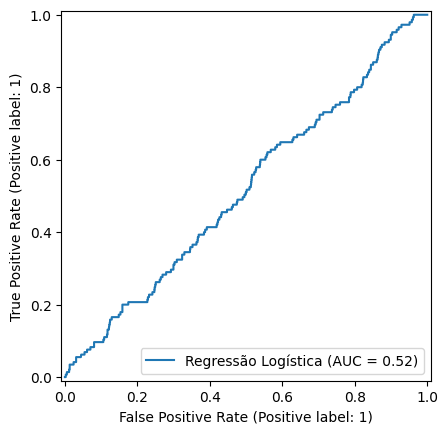

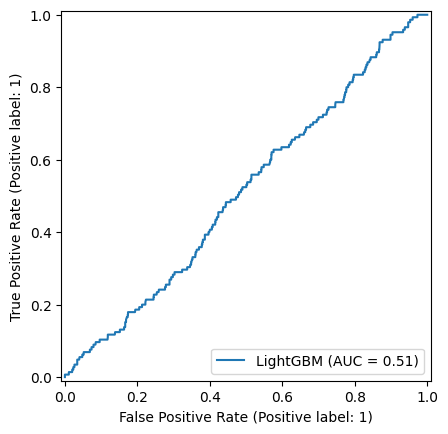

In [170]:
# ===============================
# RESULTADOS
# ===============================
for model_name, y_proba, auc, cutoff, ks in [
    ("Logit", y_pred_proba_logit, auc_logit, cutoff_logit, ks_logit),
    ("LightGBM", y_pred_proba_lgbm, auc_lgbm, cutoff_lgbm, ks_lgbm)
]:
    print(f"\n{model_name} -> AUC: {auc:.3f}, KS: {ks:.3f}, Cutoff ótimo: {cutoff:.3f}")
    
    y_pred = (y_proba >= cutoff).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Matriz de confusão (cutoff {cutoff:.3f}):\n{cm}")
    print(f"Precisão: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

# ===============================
# CURVAS ROC
# ===============================

RocCurveDisplay.from_predictions(y_test, y_pred_proba_logit, name="Regressão Logística")
RocCurveDisplay.from_predictions(y_test, y_pred_proba_lgbm, name="LightGBM")
plt.show()



Taxa de default (y=1): 0.10104384133611691

Distribuição do target:
 atraso_90d
0.0    4306
1.0     484
Name: count, dtype: int64


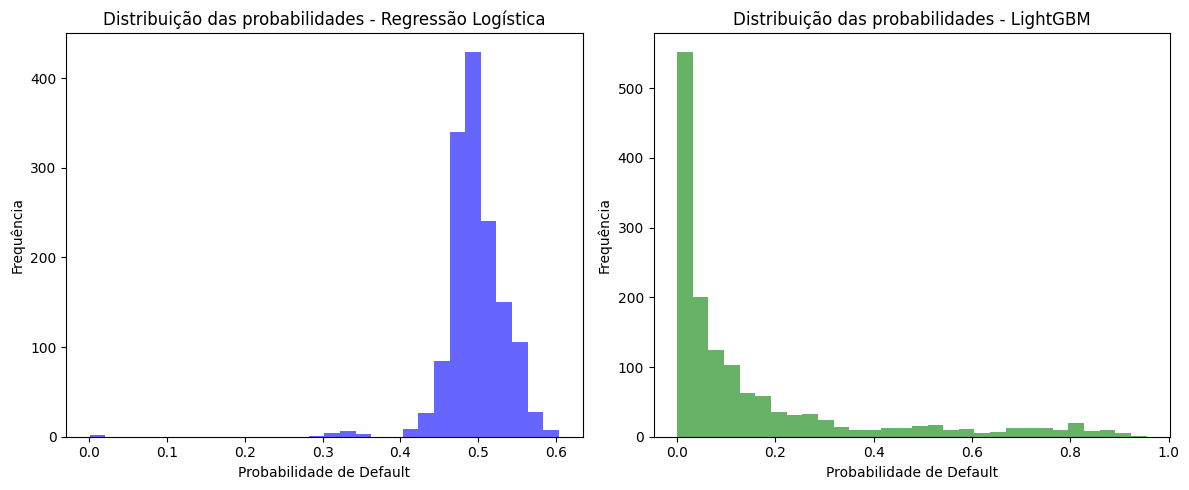

In [171]:
import matplotlib.pyplot as plt

# -------------------------------
# 1. Diagnóstico do target
# -------------------------------
print("Taxa de default (y=1):", abt["atraso_90d"].mean())
print("\nDistribuição do target:\n", abt["atraso_90d"].value_counts())

# -------------------------------
# 2. Histograma das probabilidades previstas
# -------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(y_pred_proba_logit, bins=30, alpha=0.6, color="blue")
plt.title("Distribuição das probabilidades - Regressão Logística")
plt.xlabel("Probabilidade de Default")
plt.ylabel("Frequência")

plt.subplot(1,2,2)
plt.hist(y_pred_proba_lgbm, bins=30, alpha=0.6, color="green")
plt.title("Distribuição das probabilidades - LightGBM")
plt.xlabel("Probabilidade de Default")
plt.ylabel("Frequência")

plt.tight_layout()
plt.show()


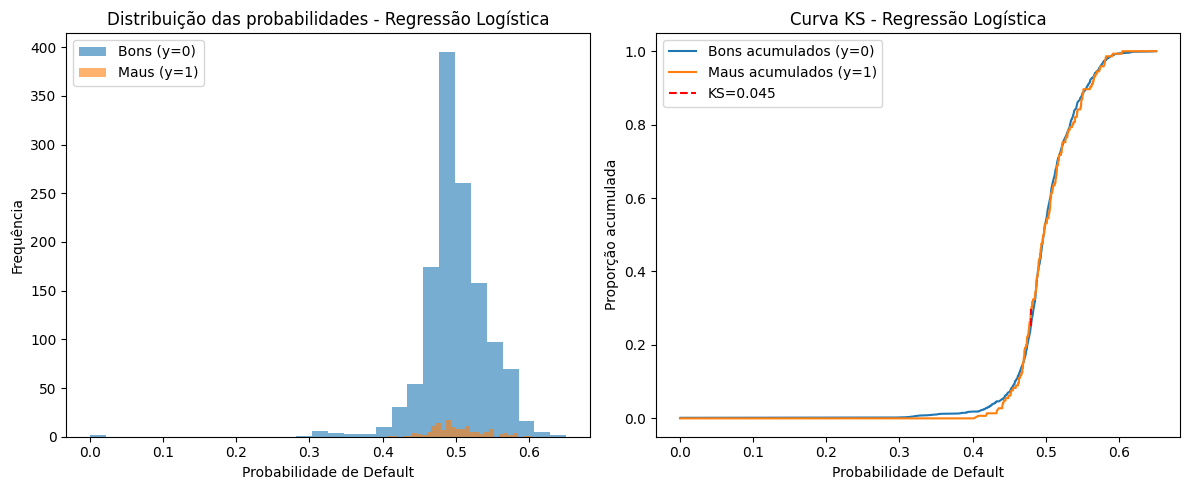

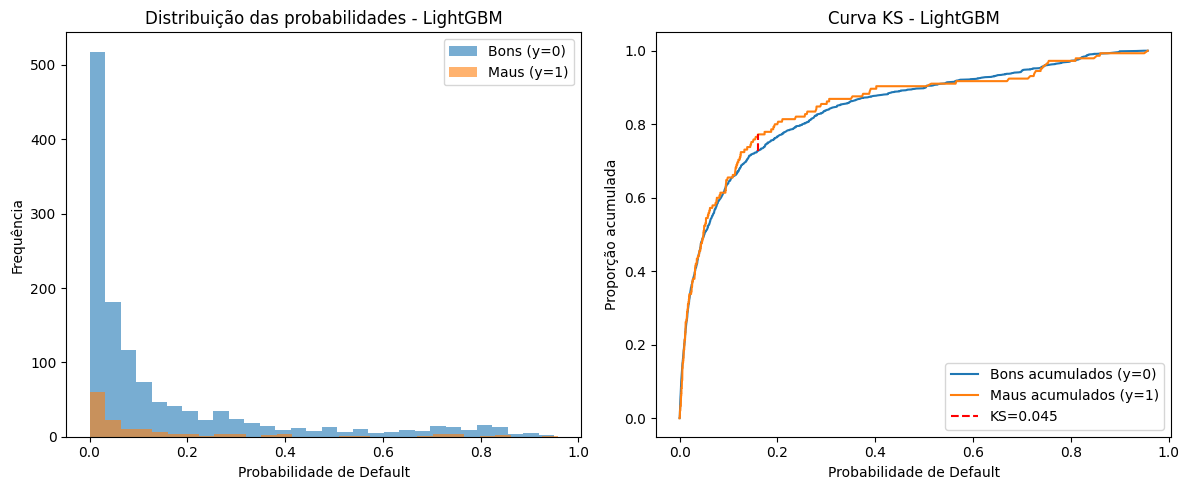

Regressão Logística  -> KS: 0.045 @ cutoff 0.480
LightGBM -> KS: 0.045 @ cutoff 0.161


In [159]:
def diagnostico_modelo(y_true, y_pred_proba, nome_modelo="Modelo"):
    df = pd.DataFrame({"y": y_true, "score": y_pred_proba})
    df = df.sort_values("score", ascending=True)

    # Acumulados
    df["cum_good"] = (df["y"] == 0).cumsum() / (df["y"] == 0).sum()
    df["cum_bad"]  = (df["y"] == 1).cumsum() / (df["y"] == 1).sum()
    df["ks"] = abs(df["cum_bad"] - df["cum_good"])

    # Ponto de KS máximo
    idx_max = df["ks"].idxmax()
    ks_val = df.loc[idx_max, "ks"]
    score_ks = df.loc[idx_max, "score"]

    # Plot conjunto
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # 1) Histograma por classe
    axes[0].hist(df.loc[df["y"]==0, "score"], bins=30, alpha=0.6, label="Bons (y=0)")
    axes[0].hist(df.loc[df["y"]==1, "score"], bins=30, alpha=0.6, label="Maus (y=1)")
    axes[0].set_title(f"Distribuição das probabilidades - {nome_modelo}")
    axes[0].set_xlabel("Probabilidade de Default")
    axes[0].set_ylabel("Frequência")
    axes[0].legend()

    # 2) Curva KS
    axes[1].plot(df["score"], df["cum_good"], label="Bons acumulados (y=0)")
    axes[1].plot(df["score"], df["cum_bad"], label="Maus acumulados (y=1)")
    axes[1].vlines(x=score_ks, ymin=df.loc[idx_max,"cum_good"], ymax=df.loc[idx_max,"cum_bad"],
                   colors="red", linestyles="--", label=f"KS={ks_val:.3f}") #@ cutoff {score_ks:.3f}")
    axes[1].set_title(f"Curva KS - {nome_modelo}")
    axes[1].set_xlabel("Probabilidade de Default")
    axes[1].set_ylabel("Proporção acumulada")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return ks_val, score_ks

# =======================
# Rodar diagnóstico
# =======================
ks_logit, cutoff_logit = diagnostico_modelo(y_test, y_pred_proba_logit, "Regressão Logística")
ks_lgbm, cutoff_lgbm   = diagnostico_modelo(y_test, y_pred_proba_lgbm, "LightGBM")

print(f"Regressão Logística  -> KS: {ks_logit:.3f} @ cutoff {cutoff_logit:.3f}")
print(f"LightGBM -> KS: {ks_lgbm:.3f} @ cutoff {cutoff_lgbm:.3f}")


A estratégia a ser seguida daqui em diante é de 